<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/08_pytorch_paper_replicating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Notes:  Reading Machine Learning Papers**

**Paper:** An image is worth 16x16 words (Attention is all you need)

**Transformers:** This is a deep-learning model that adopts the mechanism of self-attention, differentially weighing the significance of each part of input data (Wikipedia).

**Attention:** This is the most vivid part of an image that captures your eyes and delivers the image as a whole. E.g., a dog in the grass by a tree under daylight.

Attention uses selective focus, importance weighting, context dependence, relationships, and probabilistic models.

**Sources:**
- arxiv.org
- AK-Twitter (@akallz)
- vit-pytorch
- paperswithcode.com

We will transform the paper into a usable/deeper-get set.

**Paper overview:**
1. Get set up
2. Introduce machine learning paper replication
3. Replicate ViT for food-vision-mini
4. Train a custom ViT
5. Feature extraction with a pretrained ViT

---

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-applying-vit-to-food-vision-mini.png" alt="appyling the vision transformer architecture to FoodVision mini" width=900/>

We're going to be focusing on building the ViT architecture as per the original ViT paper and applying it to FoodVision Mini.

| **Topic** | **Contents** |
| ----- | ----- |
| **[0. Getting setup](https://www.learnpytorch.io/08_pytorch_paper_replicating/#0-getting-setup)** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **[1. Get data](https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data)** | Let's get the pizza, steak and sushi image classification dataset we've been using and build a Vision Transformer to try and improve FoodVision Mini model's results. |
| **[2. Create Datasets and DataLoaders](https://www.learnpytorch.io/08_pytorch_paper_replicating/#2-create-datasets-and-dataloaders)** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **[3. Replicating the ViT paper: an overview](https://www.learnpytorch.io/08_pytorch_paper_replicating/#3-replicating-the-vit-paper-an-overview)** | Replicating a machine learning research paper can be bit a fair challenge, so before we jump in, let's break the ViT paper down into smaller chunks, so we can replicate the paper chunk by chunk. |
| **[4. Equation 1: The Patch Embedding](https://www.learnpytorch.io/08_pytorch_paper_replicating/#4-equation-1-split-data-into-patches-and-creating-the-class-position-and-patch-embedding)** | The ViT architecture is comprised of four main equations, the first being the patch and position embedding. Or turning an image into a sequence of learnable patches. |
| **[5. Equation 2: Multi-Head Attention (MSA)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#5-equation-2-multi-head-attention-msa)** | The self-attention/multi-head self-attention (MSA) mechanism is at the heart of every Transformer architecture, including the ViT architecture, let's create an MSA block using PyTorch's in-built layers. |
| **[6. Equation 3: Multilayer Perceptron (MLP)](https://www.learnpytorch.io/08_pytorch_paper_replicating/#6-equation-3-multilayer-perceptron-mlp)** | The ViT architecture uses a multilayer perceptron as part of its Transformer Encoder and for its output layer. Let's start by creating an MLP for the Transformer Encoder. |
| **[7. Creating the Transformer Encoder](https://www.learnpytorch.io/08_pytorch_paper_replicating/#7-create-the-transformer-encoder)** | A Transformer Encoder is typically comprised of alternating layers of MSA (equation 2) and MLP (equation 3) joined together via residual connections. Let's create one by stacking the layers we created in sections 5 & 6 on top of each other.  |
| **[8. Putting it all together to create ViT](https://www.learnpytorch.io/08_pytorch_paper_replicating/#8-putting-it-all-together-to-create-vit)** | We've got all the pieces of the puzzle to create the ViT architecture, let's put them all together into a single class we can call as our model. |
| **[9. Setting up training code for our ViT model](https://www.learnpytorch.io/08_pytorch_paper_replicating/#9-setting-up-training-code-for-our-vit-model)** | Training our custom ViT implementation is similar to all of the other model's we've trained previously. And thanks to our `train()` function in `engine.py` we can start training with a few lines of code. |
| **[10. Using a pretrained ViT from `torchvision.models`](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-using-a-pretrained-vit-from-torchvisionmodels-on-the-same-dataset)** | Training a large model like ViT usually takes a fair amount of data. Since we're only working with a small amount of pizza, steak and sushi images, let's see if we can leverage the power of transfer learning to improve our performance. |
| **[11. Make predictions on a custom image](https://www.learnpytorch.io/08_pytorch_paper_replicating/#11-make-predictions-on-a-custom-image)** | The magic of machine learning is seeing it work on your own data, so let's take our best performing model and put FoodVision Mini to the test on the infamous *pizza-dad* image (a photo of my dad eating pizza). |

# 0. Getting Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 23.31 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#1.  Get data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

# 2. Create datasets and dataloaders

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7acf29ede680>,
 ['pizza', 'steak', 'sushi'])

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

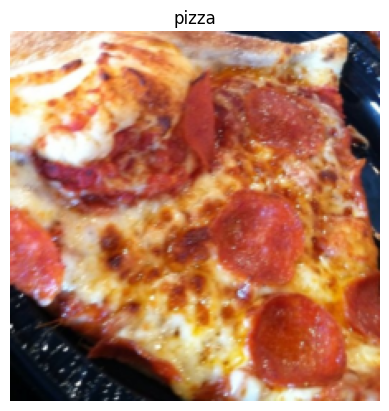

In [13]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0)) # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

#3 Replicating ViT Paper

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-intputs-outputs-layers-and-blocks.png" alt="inputs and outputs, layers and blocks of a model" width=900/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs.png" width=900 alt="figure 1 from the original vision transformer paper"/>


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-inputs-and-outputs-food-mini.png" width=900 alt="figure 1 from the original vision transformer paper adapted to work with food images, an image of pizza goes in and gets classified as 'pizza'"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png" width=650 alt="four mathematical equations from the vision transformer machine learning paper"/>

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-mapping-the-four-equations-to-figure-1.png" width=1000 alt="mapping the vision transformer paper figure 1 to the four equations listed in the paper"/>



**Attention Formulae:**

\begin{align}
        \text{Attention}(Q, K, V) = \text{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
    \end{align}

- $ Q =  Query$
- $ K =  Key$
- $ V =  Value$
- $ T =  Transpose$

**Looking at a whole machine learning research paper can be intimidating. So, in order to make it more approachable, we can break it down into smaller pieces:**

1. **Inputs:** What goes into the model.
2. **Outputs:** What comes out of the model.
3. **Layers:** Takes input, manipulates it with a function, e.g., self-attention.
4. **Blocks:** Collection of layers.
5. **Model:** A collection of blocks.

**Steps on breaking down the model:**

1. Visual overview of the architecture.
2. Four equations defining each block.
3. Different hyperparameters used.
4. Test.




**Visual overview of the architecture**

1. **Model Architecture Overview**
   - We will split the image into learnable patches instead of pixels.
     - e.g., split the image into 9 parts and send them to the transformer.
   - So the inputs are the patch position embeddings.
   - The layers are:
     - Embedded patches
     - Norm
     - Multihead attention
     - Norm
     - MLP (Multi-Layer Perceptron)
   - Notice that the input to the first norm is also added to the second norm in the diagram, indicated by the arrow.

- We have two blocks:
  - **MSA block:** Norm + Multihead attention
  - **MLP block:** Norm + MLP

**MSA** = Multi-Self-Attention layer  
**MLP** = Multi-Layer Perceptron



Equation 1

To handle 3D image, we reshape the image
$x \in \mathbb{R}^{H \times W \times C}$ (x is an element of real number with
dimension height, width, color channel) into a
sequence of flattened 2D paches $x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$
where ($P^2$) is the resolution of the image patch.
$N = \frac{H \times W}{P^2}$ is the resulting number of patches

The standard Transformer receives input as 1D thus we
multiply the resulting patches by E to map the
patches onto D dimensions.
Thus
$Z_0 = \left[ x_{\text{class}}; x_p^1E; x_p^2E; \ldots; x_p^NE \right] + E_{\text{pos}}$

- $(x_{\text{class}}$) is the class token.
- $(x_p^iE$) are the patch embeddings for $(i \in \{1, \ldots, N\}$).
- $(E_{\text{pos}}$) is the positional embedding.

(The first equation of section 3.1 GELU ViT)
Where p represents Patch, x_in the input
and pos is the positional embedding.



--------------------



```python
x-input = [class_token, image_patch_1, image_patch_2 ...image_patch_N] +
          [class_token_pos, image_patch_1_pos, image_patch_2_pos
          pos, ... image_patch_N]
```

$z'_l = \text{MSA}(\text{LN}(z_{l-1})) + z_{l-1}, \quad l = 1 \ldots L$

MSA is in pytorch

$z_l = \text{MLP}(\text{LN}(z'_l)) + z'_l$

MLP function is in pytorch:

$z_l$ and $z'_l$ are residual connection:
In the process of training, if the tensors being trained
on become too small, our loss gradient will explode.
Thus we can retain the input and pass it to the
input of the next block

* Equation 2 in pseudocode:
```
x_output_msa_block = MSA_layer(LN_layer(x_input)) + x_input
```
Equation 3
```
x_output_MLP_block = MLP_layer(LN_layer(x_output_msa_block)) +
                     x_output_msa_block
```
--------------------


Equation 4

$y = \text{MLP}(\text{LN}(z_L^0))$    where LN = Layer Norm

We know that MLP = Multilayer perceptron which is
a network neural network with x number of layers

So, we will add a class token to the beginning of
The sequence of embedded patches ie ($z_0^0$ = x_class)

Pseudocode:
```
y = LN
y = Linear_Layer(LN_layer(x_output_MLP_Block))
```
--------------------



Here is Table 1 from the Vision Transformer (ViT) paper:

| Model     | Layers | Hidden size | MLP size | Heads | Params |
|-----------|--------|-------------|----------|-------|--------|
| ViT-Base  | 12     | 768         | 3072     | 12    | 86M    |
| ViT-Large | 24     | 1024        | 4096     | 16    | 307M   |
| ViT-Huge  | 32     | 1280        | 5120     | 16    | 632M   |

This table provides details of the different Vision Transformer model variants, specifying the number of layers, hidden size, MLP size, number of attention heads, and the total number of parameters for each model.

# 4. Equations to code

## 4.1 Equation 1: Calculate input and output shapes

In [10]:
# create example values
height = 224
width = 224
color_channel = 3
patch_size = 16

# calculae number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [11]:
# input shape
embedding_layer_input_shape = (height, width, color_channel)

# output_shape
embedding_layer_output_shape = (number_of_patches, (patch_size**2) * color_channel )
print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


## 4.2 Turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

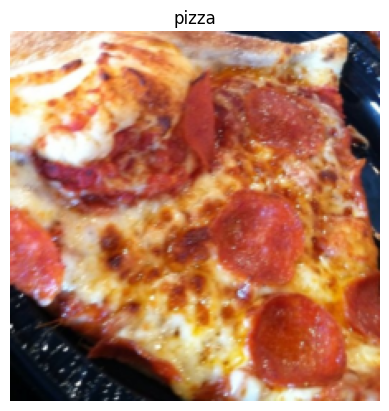

In [16]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

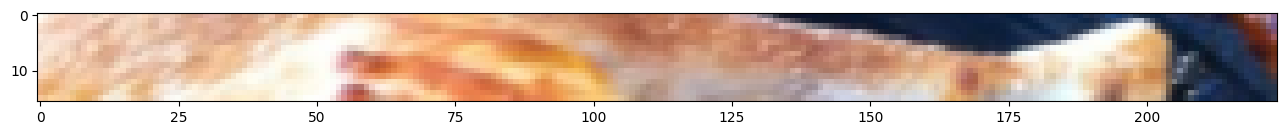

In [17]:
# get top row of image
image_permuted = image.permute(1,2,0)

# index to plot the top row of image
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

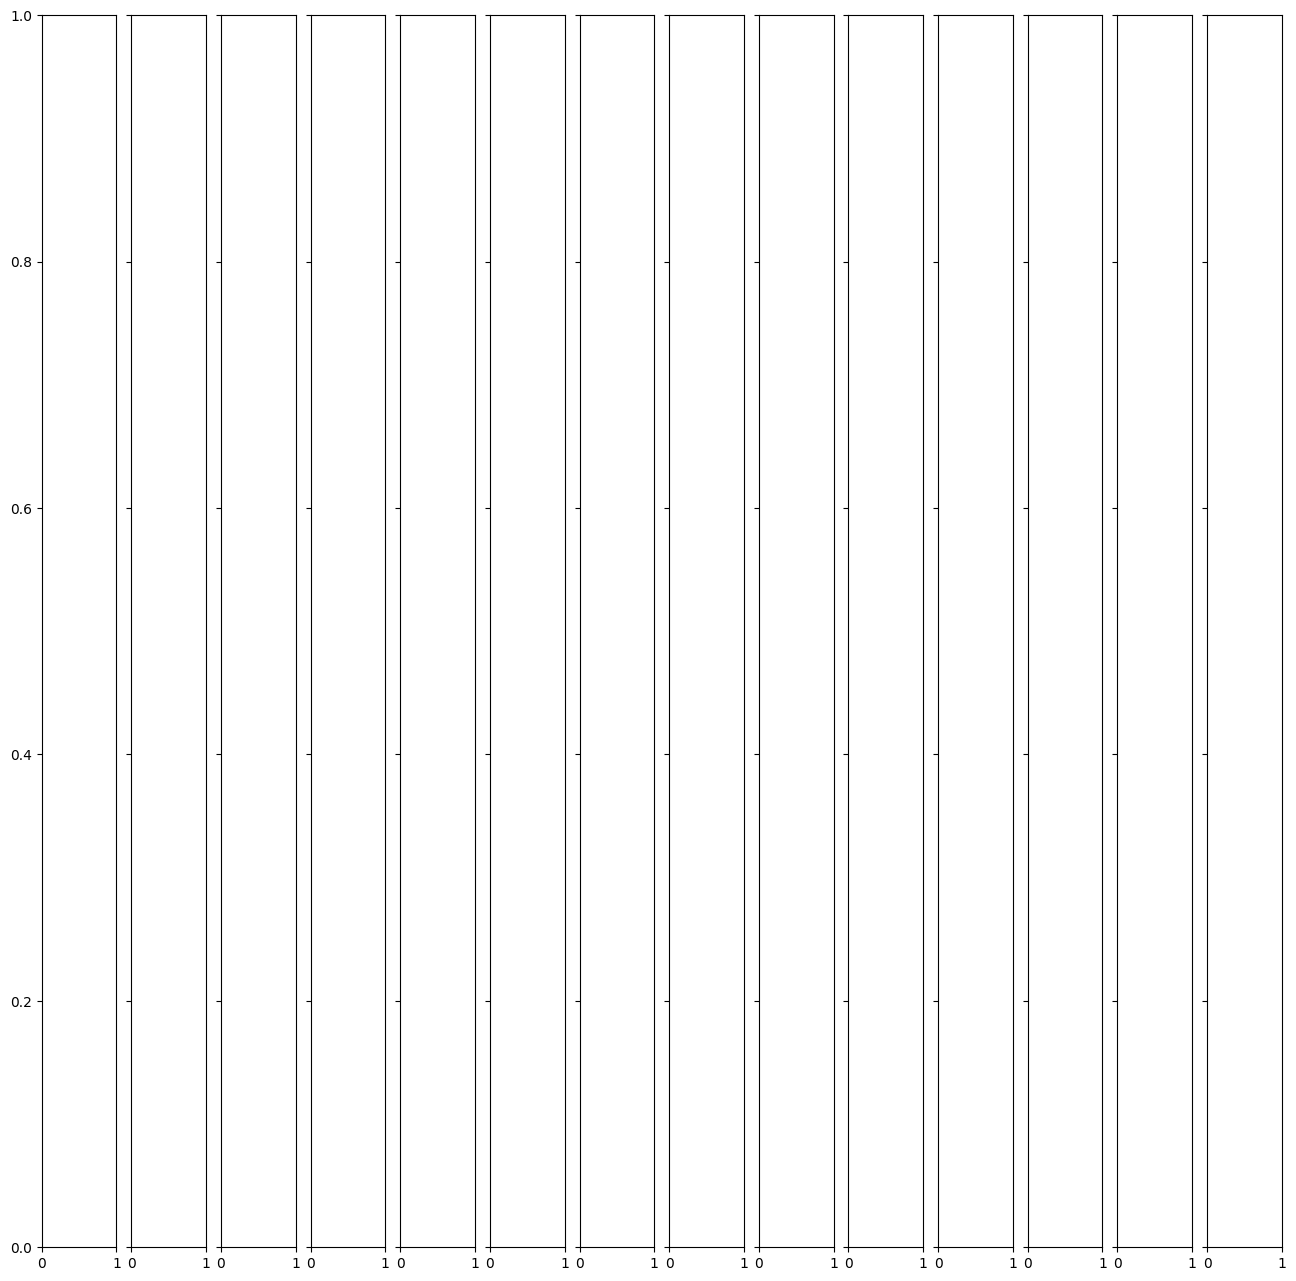

In [26]:
# plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Image size must be divisible by patch size"

# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))

for i, patch_i in enumerate(range(0, img_size, patch_size)):
    for j, patch_j in enumerate(range(0, img_size, patch_size)):
        # print(patch)
        image_patch = image_permuted[patch_i:patch_i+patch_size, patch_j:patch_j+patch_size , :]
        axs[i,j].imshow(image_patch)
        axs[i,j].set_xlabel(i+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])